In [1]:
%pip install datasets -q
%pip install accelerate -U -q
%pip install transformers -q
%pip install scikit-learn==1.3.2 -q

In [2]:
import urllib
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score
from datasets import Dataset
import torch
from transformers import (
    BertModel,
    BertTokenizer,
)
import os
import matplotlib.pyplot as plt
import tqdm.notebook as tq

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: %s" % device)

Device: cuda


## TASK 1: Corpus


In [4]:
### Argument urls
argument_urls = {
    "train": "https://zenodo.org/records/8248658/files/arguments-training.tsv?download=1",
    "validation": "https://zenodo.org/records/8248658/files/arguments-validation.tsv?download=1",
    "test": "https://zenodo.org/records/8248658/files/arguments-test.tsv?download=1",
}

### Human values urls
level2_values_urls = {
    "train": "https://zenodo.org/records/8248658/files/labels-training.tsv?download=1",
    "validation": "https://zenodo.org/records/8248658/files/labels-validation.tsv?download=1",
    "test": "https://zenodo.org/records/8248658/files/labels-test.tsv?download=1",
}
### Check that the splits in the dict keys were not misspelled
for split in level2_values_urls.keys():
    assert split in argument_urls.keys(), "url dictionary keys misspelled"

In [5]:
### Create Data folder
data_folder = Path.cwd().joinpath("Data")
if not data_folder.exists():
    data_folder.mkdir(parents=True)

### Path for each file
argument_paths = {
    split: data_folder.joinpath(f"arguments_{split}.tsv")
    for split in argument_urls.keys()
}
level2_values_paths = {
    split: data_folder.joinpath(f"labels_{split}.tsv")
    for split in level2_values_urls.keys()
}

### Download each file if it's not already there
for file, path in argument_paths.items():
    if not path.exists():
        urllib.request.urlretrieve(argument_urls[file], filename=path)
for file, path in level2_values_paths.items():
    if not path.exists():
        urllib.request.urlretrieve(level2_values_urls[file], filename=path)

In [6]:
### Read arguments file (split = train/validation/test)
argument_dfs = {
    split: pd.read_csv(path, sep="\t") for split, path in argument_paths.items()
}

### Read human values file (split = train/validation/test)
level2_values_dfs = {
    values_split: pd.read_csv(path, sep="\t")
    for values_split, path in level2_values_paths.items()
}

In [7]:
### Merge arguments and (labels) level 2 values (split = train/validation/test)
args_level2vals_dfs = {
    split: pd.merge(argument, level2_values_dfs[split], on="Argument ID")
    for split, argument in argument_dfs.items()
}

In [8]:
level2_values_dfs["train"].head(2)

,Argument ID,Self-direction: thought,Self-direction: action,Stimulation,Hedonism,Achievement,Power: dominance,Power: resources,Face,Security: personal,...,Tradition,Conformity: rules,Conformity: interpersonal,Humility,Benevolence: caring,Benevolence: dependability,Universalism: concern,Universalism: nature,Universalism: tolerance,Universalism: objectivity
0,A01002,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,A01005,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [9]:
argument_dfs["train"].head(2)

,Argument ID,Conclusion,Stance,Premise
0,A01002,We should ban human cloning,in favor of,we should ban human cloning as it will only ca...
1,A01005,We should ban fast food,in favor of,fast food should be banned because it is reall...


In [10]:
args_level2vals_dfs["train"].describe()

,Self-direction: thought,Self-direction: action,Stimulation,Hedonism,Achievement,Power: dominance,Power: resources,Face,Security: personal,Security: societal,Tradition,Conformity: rules,Conformity: interpersonal,Humility,Benevolence: caring,Benevolence: dependability,Universalism: concern,Universalism: nature,Universalism: tolerance,Universalism: objectivity
count,5393.000000,5393.000000,5393.000000,5393.000000,5393.000000,5393.000000,5393.000000,5393.000000,5393.000000,5393.000000,5393.000000,5393.000000,5393.000000,5393.000000,5393.000000,5393.000000,5393.000000,5393.000000,5393.000000,5393.000000
mean,0.183200,0.258669,0.045800,0.031893,0.280363,0.113110,0.115891,0.070833,0.370851,0.320415,0.105322,0.218246,0.038383,0.073243,0.246987,0.149453,0.385871,0.079177,0.123123,0.195439
std,0.386867,0.437944,0.209071,0.175732,0.449218,0.316756,0.320124,0.256569,0.483077,0.466679,0.306996,0.413094,0.192137,0.260559,0.431299,0.356567,0.486845,0.270039,0.328608,0.396575
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
args_level2vals_dfs["train"].head(2)

,Argument ID,Conclusion,Stance,Premise,Self-direction: thought,Self-direction: action,Stimulation,Hedonism,Achievement,Power: dominance,...,Tradition,Conformity: rules,Conformity: interpersonal,Humility,Benevolence: caring,Benevolence: dependability,Universalism: concern,Universalism: nature,Universalism: tolerance,Universalism: objectivity
0,A01002,We should ban human cloning,in favor of,we should ban human cloning as it will only ca...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,A01005,We should ban fast food,in favor of,fast food should be banned because it is reall...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
### Considering category ranges (0,3),(3,7),(7,13),(13,19)
### adding +4, considering the first 4 columns which are not categories
level3_categories_ranges = {
    "Openness_to_change": (4, 7),
    "Self_enhancement": (7, 11),
    "Conversation": (11, 17),
    "Self_transcendence": (17, 23),
}
columns_to_keep = ["Argument ID", "Conclusion", "Stance", "Premise"]
level_3_cat = list(level3_categories_ranges.keys())

In [13]:
### Creating final dataframes
train, validation, test = args_level2vals_dfs.keys()
assert train == "train" and validation == "validation" and test == "test"

### nm = not merged
train_df_nm = args_level2vals_dfs["train"]
validation_df_nm = args_level2vals_dfs["validation"]
test_df_nm = args_level2vals_dfs["test"]

### Creating final dataframes
train_df = pd.DataFrame()
validation_df = pd.DataFrame()
test_df = pd.DataFrame()

### Merge lvl2 to lvl 3 (any = OR)
for cat, (start, end) in level3_categories_ranges.items():
    train_df[cat] = train_df_nm.iloc[:, start:end].any(axis=1)
    validation_df[cat] = validation_df_nm.iloc[:, start:end].any(axis=1)
    test_df[cat] = test_df_nm.iloc[:, start:end].any(axis=1)

### Adding the columns to keep of the original dfs
train_df = pd.concat([train_df_nm[columns_to_keep], train_df], axis=1)
validation_df = pd.concat([validation_df_nm[columns_to_keep], validation_df], axis=1)
test_df = pd.concat([test_df_nm[columns_to_keep], test_df], axis=1)

### Define a mapping for "Stance" column
stance_mapping = {"in favor of": 1, "against": 0}

### Apply the mapping to convert strings to boolean values
train_df["Stance"] = train_df["Stance"].map(stance_mapping)
validation_df["Stance"] = validation_df["Stance"].map(stance_mapping)
test_df["Stance"] = test_df["Stance"].map(stance_mapping)

dfs = {"train": train_df, "validation": validation_df, "test": test_df}

In [14]:
train_df["Conversation"].sum()

4018

In [15]:
train_df.head(2)

,Argument ID,Conclusion,Stance,Premise,Openness_to_change,Self_enhancement,Conversation,Self_transcendence
0,A01002,We should ban human cloning,1,we should ban human cloning as it will only ca...,False,False,True,False
1,A01005,We should ban fast food,1,fast food should be banned because it is reall...,False,False,True,False


In [16]:
train_df.describe()

,Stance
count,5393.000000
mean,0.537363
std,0.498648
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


# TASK 2: Model definition

## Baseline Model

In [17]:
def baseline_model(strategy, level_3_cat, train_df, columns_to_keep):
    clf_list = [DummyClassifier(strategy=strategy) for _ in level_3_cat]
    [
        clf.fit(X=train_df[columns_to_keep[1:]], y=train_df[cat])
        for clf, cat in zip(clf_list, level_3_cat)
    ]
    return clf_list

## Bert - base Classifier

In [18]:
### Convert dataframes into datasets
datasets = {split: Dataset.from_pandas(df) for split, df in dfs.items()}

In [19]:
def compute_class_weights(df, cat_labels):
    labels_array = df[cat_labels].to_numpy()
    n_ones = np.sum(labels_array, axis=0, dtype=np.single)
    weights = np.empty_like(n_ones)
    n_zeroes = np.array([labels_array.shape[0] - o for o in n_ones])

    for class_num, (ones, zeroes) in enumerate(zip(n_ones, n_zeroes)):
        weights[class_num] = zeroes / (ones + 1e-4)

    print(f"weigts = {weights}")
    return torch.as_tensor(weights, dtype=torch.float).to(device)


def compute_class_weights_root(df, cat_labels):
    labels_array = df[cat_labels].to_numpy()
    n_ones = np.sum(labels_array, axis=0, dtype=np.single)
    weights = np.empty_like(n_ones)
    n_zeroes = np.array([labels_array.shape[0] - o for o in n_ones])

    for class_num, ones in enumerate(n_ones):
        weights[class_num] = np.sqrt(labels_array.shape[0] / (ones + 1e-4))

    print(f"weigts = {weights}")
    return torch.as_tensor(weights, dtype=torch.float).to(device)


def loss_fn(outputs, targets, pos_weight=None):
    return torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)(outputs, targets)

In [20]:
def add_labels(ds_row, labels):
    labels_batch = {k: ds_row[k] for k in ds_row.keys() if k in labels}
    labels_matrix = np.zeros((len(ds_row["Conclusion"]), len(labels)))
    for i, label in enumerate(labels):
        labels_matrix[:, i] = labels_batch[label]
    return labels_matrix.tolist()

### NEW
### General Model

In [21]:
class BERTClass(torch.nn.Module):
    def __init__(self, stance=False):
        super().__init__()
        self.bert_model = BertModel.from_pretrained(
            "bert-base-uncased", return_dict=True
        )
        self.dropout = torch.nn.Dropout(0.3)
        if not stance:
            self.linear = torch.nn.Linear(768, len(level_3_cat))
        else:
            ### 769! there is "stance" as another input
            self.linear = torch.nn.Linear(769, len(level_3_cat))

    def forward(self, input_ids, token_type_ids, attn_mask, stance=None):
        output = self.bert_model(
            input_ids, attention_mask=attn_mask, token_type_ids=token_type_ids
        )
        output_dropout = self.dropout(output.pooler_output)

        if stance is None:
            output_linear = self.linear(output_dropout)
        else:
            ### concatenate stance
            stance = stance.view(stance.shape[0], -1)
            output_stack = torch.cat((output_dropout, stance), dim=1)
            output_linear = self.linear(output_stack)
        return output_linear

In [22]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [23]:
### Encoding
def tokenize(ds_row, tokenizer=tokenizer, premise=False, stance=False):
    ### Tokenize text columns
    print(f"PREMISE = {premise}  STANCE = {stance}")
    if not premise:
        text_tokens = tokenizer(
            ds_row["Conclusion"],
            truncation=True,
            padding="max_length",
            max_length=tokenizer.model_max_length // 2,
            return_tensors="pt",
        )
    else:
        text_tokens = tokenizer(
            ds_row["Conclusion"],
            ds_row["Premise"],
            truncation=True,
            padding="max_length",
            max_length=tokenizer.model_max_length // 2,
            return_tensors="pt",
        )

    ### Combine text tokens with non-text features
    encoded_ds_row = {
        "input_ids": text_tokens["input_ids"],
        "token_type_ids": text_tokens["token_type_ids"],
        "attention_mask": text_tokens["attention_mask"],
    }
    if stance:
        encoded_ds_row.update(
            {
                "Stance": torch.tensor(
                    ds_row["Stance"], dtype=torch.float
                ),  ### Assuming 'Stance' is represented as 0 or 1
            }
        )

    encoded_ds_row["labels"] = add_labels(ds_row, level_3_cat)

    return encoded_ds_row

tokenized_datasets = {
    split: ds.map(
        function=tokenize,
        fn_kwargs={"tokenizer": tokenizer, "premise": False, "stance": False},
        batched=True,
        remove_columns=[
            "Argument ID",
            "Conclusion",
            "Stance",
            "Premise",
            "Openness_to_change",
            "Self_enhancement",
            "Conversation",
            "Self_transcendence",
        ],
    )
    for split, ds in datasets.items()
}

In [24]:
### Training of the model
def train_model(train_dl, model, optimizer, class_weights, use_stance=False):
    #model = BERTClass()
    #model.to(device)
    losses = []
    correct_predictions = 0
    num_samples = 0

    ### activate dropout, batch norm
    model.train()

    ### initialize progress bar
    batches = tq.tqdm(
        enumerate(train_dl), total=len(train_dl), leave=True, colour="steelblue"
    )

    for batch_idx, data in batches:
        ids = data["input_ids"].to(device, dtype=torch.long)
        mask = data["attention_mask"].to(device, dtype=torch.long)
        token_type_ids = data["token_type_ids"].to(device, dtype=torch.long)
        labels = data["labels"].to(device, dtype=torch.float)
        if use_stance:
            stance = data["Stance"].to(device, dtype=torch.float)
            outputs = model(ids, token_type_ids, mask, stance)  ### Forward
        else:
            outputs = model(ids, token_type_ids, mask)  ### Forward

        loss = loss_fn(outputs, labels, class_weights)
        losses.append(loss.cpu().detach().numpy())

        ### apply thresh 0.5
        outputs = torch.sigmoid(outputs).cpu().detach().numpy().round()
        labels = labels.cpu().detach().numpy()
        correct_predictions += np.sum(outputs == labels)
        num_samples += labels.size

        ### Backward
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        ### Grad descent step
        optimizer.step()

        ### Update progress bar
        batches.set_description(f"")
        batches.set_postfix(batch_loss=loss)

    accuracy = float(correct_predictions) / num_samples
    return model, accuracy, losses

### Conclusion Only Model

class BERTConclusionClass(torch.nn.Module):
    def __init__(self):
        super(BERTConclusionClass, self).__init__()
        self.bert_model = BertModel.from_pretrained(
            "bert-base-uncased", return_dict=True
        )
        self.dropout = torch.nn.Dropout(0.3)
        self.linear = torch.nn.Linear(768, len(level_3_cat))

    def forward(self, input_ids, token_type_ids, attn_mask):
        output = self.bert_model(
            input_ids, attention_mask=attn_mask, token_type_ids=token_type_ids
        )
        output_dropout = self.dropout(output.pooler_output)
        output_linear = self.linear(output_dropout)
        return output_linear

### Encoding for Conclusion only model
def tokenize_c(ds_row, tokenizer):
    ### Tokenize text columns
    text_tokens = tokenizer(
        ds_row["Conclusion"],
        truncation=True,
        padding="max_length",
        max_length=tokenizer.model_max_length // 2,
        return_tensors="pt",
    )

    ### Combine text tokens with non-text features
    encoded_ds_row = {
        "input_ids": text_tokens["input_ids"],
        "token_type_ids": text_tokens["token_type_ids"],
        "attention_mask": text_tokens["attention_mask"],
    }

    encoded_ds_row["labels"] = add_labels(ds_row, level_3_cat)

    return encoded_ds_row

tokenized_datasets = {
    split: ds.map(
        function=tokenize_c,
        fn_kwargs={"tokenizer": tokenizer},
        batched=True,
        remove_columns=[
            "Argument ID",
            "Conclusion",
            "Stance",
            "Premise",
            "Openness_to_change",
            "Self_enhancement",
            "Conversation",
            "Self_transcendence",
        ],
    )
    for split, ds in datasets.items()
}

### Training of the model
def train_model_c(train_dl, model, optimizer, class_weights):
    model = BERTConclusionClass()
    model.to(device)
    losses = []
    correct_predictions = 0
    num_samples = 0

    ### activate dropout, batch norm
    model.train()

    ### initialize progress bar
    batches = tq.tqdm(
        enumerate(train_dl), total=len(train_dl), leave=True, colour="steelblue"
    )

    for batch_idx, data in batches:
        ids = data["input_ids"].to(device, dtype=torch.long)
        mask = data["attention_mask"].to(device, dtype=torch.long)
        token_type_ids = data["token_type_ids"].to(device, dtype=torch.long)
        labels = data["labels"].to(device, dtype=torch.float)

        ### Forward
        outputs = model(ids, token_type_ids, mask)

        loss = loss_fn(outputs, labels, class_weights)
        losses.append(loss.cpu().detach().numpy())

        ### apply thresh 0.5
        outputs = torch.sigmoid(outputs).cpu().detach().numpy().round()
        labels = labels.cpu().detach().numpy()
        correct_predictions += np.sum(outputs == labels)
        num_samples += labels.size

        ### Backward
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        ### Grad descent step
        optimizer.step()

        ### Update progress bar
        batches.set_description(f"")
        batches.set_postfix(batch_loss=loss)

    accuracy = float(correct_predictions) / num_samples
    return model, accuracy, losses

### Conclusion - Premise

class BERTConclusionPremiseClass(torch.nn.Module):
    def __init__(self):
        super(BERTConclusionPremiseClass, self).__init__()
        self.bert_model = BertModel.from_pretrained(
            "bert-base-uncased", return_dict=True
        )
        self.dropout = torch.nn.Dropout(0.3)
        self.linear = torch.nn.Linear(768, len(level_3_cat))

    def forward(self, input_ids, token_type_ids, attn_mask):
        output = self.bert_model(
            input_ids, attention_mask=attn_mask, token_type_ids=token_type_ids
        )
        output_dropout = self.dropout(output.pooler_output)
        output_linear = self.linear(output_dropout)
        return output_linear

### Encoding for Conclusion - Premise model
def tokenize_cp(ds_row, tokenizer):
    ### Tokenize text columns
    text_tokens = tokenizer(
        ds_row["Conclusion"],
        ds_row["Premise"],
        truncation=True,
        padding="max_length",
        max_length=tokenizer.model_max_length // 2,
        return_tensors="pt",
    )

    ### Combine text tokens with non-text features
    encoded_ds_row = {
        "input_ids": text_tokens["input_ids"],
        "token_type_ids": text_tokens["token_type_ids"],
        "attention_mask": text_tokens["attention_mask"],
    }
    encoded_ds_row["labels"] = add_labels(ds_row, level_3_cat)

    return encoded_ds_row

### Training of the model
def train_model_cp(train_dl, model, optimizer, class_weights):
    losses = []
    correct_predictions = 0
    num_samples = 0

    ### activate droput, batch norm
    model.train()

    ### initialize progress bar
    batches = tq.tqdm(
        enumerate(train_dl), total=len(train_dl), leave=True, colour="steelblue"
    )
    for batch_idx, data in batches:
        ids = data["input_ids"].to(device, dtype=torch.long)
        mask = data["attention_mask"].to(device, dtype=torch.long)
        token_type_ids = data["token_type_ids"].to(device, dtype=torch.long)
        labels = data["labels"].to(device, dtype=torch.float)

        ### Forward
        outputs = model(ids, token_type_ids, mask)
        loss = loss_fn(outputs, labels, class_weights)
        losses.append(loss.cpu().detach().numpy())

        ### thresh 0.5
        outputs = torch.sigmoid(outputs).cpu().detach().numpy().round()
        labels = labels.cpu().detach().numpy()
        correct_predictions += np.sum(outputs == labels)
        num_samples += labels.size

        ### Backward
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        ### Grad descent step
        optimizer.step()

        ### Update progress bar
        batches.set_description(f"")
        batches.set_postfix(batch_loss=loss)

    accuracy = float(correct_predictions) / num_samples
    return model, accuracy, losses

### Conclusion - Premise - Stance

class BERTConclusionPremiseStanceClass(torch.nn.Module):
    def __init__(self):
        super(BERTConclusionPremiseStanceClass, self).__init__()
        self.bert_model = BertModel.from_pretrained(
            "bert-base-uncased", return_dict=True
        )
        self.dropout = torch.nn.Dropout(0.3)
        self.linear = torch.nn.Linear(
            769, len(level_3_cat)
        )  ### 769! there is "stance" as another input

    def forward(self, input_ids, token_type_ids, attn_mask, stance):
        output = self.bert_model(
            input_ids, attention_mask=attn_mask, token_type_ids=token_type_ids
        )
        output_dropout = self.dropout(output.pooler_output)
        ### concatenate stance
        stance = stance.view(stance.shape[0], -1)
        output_stack = torch.cat((output_dropout, stance), dim=1)
        output_linear = self.linear(output_stack)
        return output_linear

### Encoding for Conclusion - Premise - Stance model
def tokenize_cps(ds_row, tokenizer):
    ### Tokenize text columns
    text_tokens = tokenizer(
        ds_row["Conclusion"],
        ds_row["Premise"],
        truncation=True,
        padding="max_length",
        max_length=tokenizer.model_max_length // 2,
        return_tensors="pt",
    )

    ### Combine text tokens with non-text features
    encoded_ds_row = {
        "input_ids": text_tokens["input_ids"],
        "token_type_ids": text_tokens["token_type_ids"],
        "attention_mask": text_tokens["attention_mask"],
        "Stance": torch.tensor(
            ds_row["Stance"], dtype=torch.float
        ),  ### Assuming 'Stance' is represented as 0 or 1
    }
    encoded_ds_row["labels"] = add_labels(ds_row, level_3_cat)

    return encoded_ds_row

### Training of the model
def train_model_cps(train_dl, model, optimizer, class_weights):
    losses = []
    correct_predictions = 0
    num_samples = 0

    ### activate droput, batch norm
    model.train()

    ### initialize progress bar
    batches = tq.tqdm(
        enumerate(train_dl), total=len(train_dl), leave=True, colour="steelblue"
    )

    for batch_idx, data in batches:
        ids = data["input_ids"].to(device, dtype=torch.long)
        mask = data["attention_mask"].to(device, dtype=torch.long)
        token_type_ids = data["token_type_ids"].to(device, dtype=torch.long)
        labels = data["labels"].to(device, dtype=torch.float)
        stance = data["Stance"].to(device, dtype=torch.float)

        ### Forward
        outputs = model(ids, token_type_ids, mask, stance)
        loss = loss_fn(outputs, labels, class_weights)
        losses.append(loss.cpu().detach().numpy())

        ### Training accuracy, apply sigmoid, round (apply thresh 0.5)
        outputs = torch.sigmoid(outputs).cpu().detach().numpy().round()
        labels = labels.cpu().detach().numpy()
        correct_predictions += np.sum(outputs == labels)
        num_samples += labels.size

        ### Backward
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        ### Grad descent step
        optimizer.step()

        ### Update progress bar
        batches.set_description(f"")
        batches.set_postfix(batch_loss=loss)

    accuracy = float(correct_predictions) / num_samples
    return model, accuracy, losses

# Task 3: Metrics

### Baseline Metric

In [25]:
def f1_baseline(prediction, labels, data):
    ### Evaluate F1 overall
    f1_overall = f1_score(
        y_true=data[labels], y_pred=prediction, average="macro", zero_division=np.nan
    )

    ### Evaluate F1 per category
    f1_per_cat = [
        f1_score(y_true=data[cat], y_pred=prediction[:, i])
        for i, cat in enumerate(labels)
    ]

    return f1_overall, f1_per_cat

### NEW
### BERT BASE METRIC

In [26]:
def eval_model(validation_dl, model, class_weights, use_stance=False):
    losses = []
    correct_predictions = 0
    num_samples = 0
    num_categories = next(iter(validation_dl))["labels"].shape[1]

    ### accumulate data over each batch to compute the f1
    true_positives = np.array([0 for _ in range(num_categories)])
    false_positives = np.array([0 for _ in range(num_categories)])
    false_negatives = np.array([0 for _ in range(num_categories)])

    ### turn off dropout, fix batch norm
    model.eval()

    ### show progress bar
    batches = tq.tqdm(
        enumerate(validation_dl),
        total=len(validation_dl),
        leave=True,
        colour="steelblue",
    )
    # batches = enumerate(validation_dl)
    with torch.no_grad():
        for batch_idx, data in batches:
            ids = data["input_ids"].to(device, dtype=torch.long)
            mask = data["attention_mask"].to(device, dtype=torch.long)
            token_type_ids = data["token_type_ids"].to(device, dtype=torch.long)
            labels = data["labels"].to(device, dtype=torch.float)
            if use_stance:
                stance = data["Stance"].to(device, dtype=torch.float)
                outputs = model(ids, token_type_ids, mask, stance)  ### Forward
            else:
                outputs = model(ids, token_type_ids, mask)

            loss = loss_fn(outputs, labels, class_weights)
            losses.append(loss.cpu().detach().numpy())

            ### validation accuracy
            ### training sigmoid is in BCEWithLogitsLoss
            outputs = torch.sigmoid(outputs).cpu().detach().numpy().round()
            labels = labels.cpu().detach().numpy()
            correct_predictions += np.sum(outputs == labels)
            num_samples += labels.size

            ### TP: predicttion == 1, true label == 1
            true_positives += np.array(
                [
                    np.sum(np.logical_and(outputs[:, i] == 1, labels[:, i] == 1))
                    for i in range(num_categories)
                ]
            )

            ### FP: prediction == 1, true label == 0
            false_positives += np.array(
                [
                    np.sum(np.logical_and(outputs[:, i] == 1, labels[:, i] == 0))
                    for i in range(num_categories)
                ]
            )

            ### FN: prediction == 0, true label == 1
            false_negatives += np.array(
                [
                    np.sum(np.logical_and(outputs[:, i] == 0, labels[:, i] == 1))
                    for i in range(num_categories)
                ]
            )

        accuracy = float(correct_predictions) / num_samples
        precision = true_positives / (true_positives + false_positives)
        recall = true_positives / (true_positives + false_negatives)
        f1_per_cat = 2 * (precision * recall) / (precision + recall)
        f1_overall = np.mean(f1_per_cat)
    return accuracy, losses, f1_overall, f1_per_cat

### Bert Conclusion-Only Model Metric

def eval_model_c(validation_dl, model, class_weights):
    losses = []
    correct_predictions = 0
    num_samples = 0
    num_categories = next(iter(validation_dl))["labels"].shape[1]

    ### accumulate data over each batch to compute the f1
    true_positives = np.array([0 for _ in range(num_categories)])
    false_positives = np.array([0 for _ in range(num_categories)])
    false_negatives = np.array([0 for _ in range(num_categories)])

    ### set model to eval mode (turn off dropout, fix batch norm)
    model.eval()

    ### show progress bar
    batches = tq.tqdm(
        enumerate(validation_dl),
        total=len(validation_dl),
        leave=True,
        colour="steelblue",
    )
    # batches = enumerate(validation_dl)
    with torch.no_grad():
        for batch_idx, data in batches:
            ids = data["input_ids"].to(device, dtype=torch.long)
            mask = data["attention_mask"].to(device, dtype=torch.long)
            token_type_ids = data["token_type_ids"].to(device, dtype=torch.long)
            labels = data["labels"].to(device, dtype=torch.float)
            outputs = model(ids, token_type_ids, mask)

            loss = loss_fn(outputs, labels, class_weights)
            losses.append(loss.cpu().detach().numpy())

            ### validation accuracy

            ### training sigmoid is in BCEWithLogitsLoss
            outputs = torch.sigmoid(outputs).cpu().detach().numpy().round()
            labels = labels.cpu().detach().numpy()
            correct_predictions += np.sum(outputs == labels)
            num_samples += labels.size

            ### TP: predicttion == 1, true label == 1.
            true_positives += np.array(
                [
                    np.sum(np.logical_and(outputs[:, i] == 1, labels[:, i] == 1))
                    for i in range(num_categories)
                ]
            )

            ### FP: prediction == 1, true label == 0
            false_positives += np.array(
                [
                    np.sum(np.logical_and(outputs[:, i] == 1, labels[:, i] == 0))
                    for i in range(num_categories)
                ]
            )

            ### FN: prediction == 0, true label == 1
            false_negatives += np.array(
                [
                    np.sum(np.logical_and(outputs[:, i] == 0, labels[:, i] == 1))
                    for i in range(num_categories)
                ]
            )

        accuracy = float(correct_predictions) / num_samples
        precision = true_positives / (true_positives + false_positives)
        recall = true_positives / (true_positives + false_negatives)
        f1_per_cat = 2 * (precision * recall) / (precision + recall)
        f1_overall = np.mean(f1_per_cat)

    return accuracy, losses, f1_overall, f1_per_cat

### Bert Conclusion - Premise Model Metric

def eval_model_cp(validation_dl, model, class_weights):
    losses = []
    correct_predictions = 0
    num_samples = 0
    num_categories = next(iter(validation_dl))["labels"].shape[1]

    ### accumulate data over each batch to compute the f1
    true_positives = np.array([0 for _ in range(num_categories)])
    false_positives = np.array([0 for _ in range(num_categories)])
    false_negatives = np.array([0 for _ in range(num_categories)])

    ### turn off dropout, fix batch norm
    model.eval()

    ### show progress bar
    batches = tq.tqdm(
        enumerate(validation_dl),
        total=len(validation_dl),
        leave=True,
        colour="steelblue",
    )
    with torch.no_grad():
        for batch_idx, data in batches:
            ids = data["input_ids"].to(device, dtype=torch.long)
            mask = data["attention_mask"].to(device, dtype=torch.long)
            token_type_ids = data["token_type_ids"].to(device, dtype=torch.long)
            labels = data["labels"].to(device, dtype=torch.float)
            outputs = model(ids, token_type_ids, mask)

            loss = loss_fn(outputs, labels, class_weights)  # maybe remove class weights
            losses.append(loss.cpu().detach().numpy())

            ### validation accuracy

            ### training sigmoid is in BCEWithLogitsLoss
            outputs = torch.sigmoid(outputs).cpu().detach().numpy().round()
            labels = labels.cpu().detach().numpy()
            correct_predictions += np.sum(outputs == labels)
            num_samples += labels.size

            ### TP: predicttion == 1, true label == 1.
            true_positives += np.array(
                [
                    np.sum(np.logical_and(outputs[:, i] == 1, labels[:, i] == 1))
                    for i in range(num_categories)
                ]
            )

            ### FP: prediction == 1, true label == 0
            false_positives += np.array(
                [
                    np.sum(np.logical_and(outputs[:, i] == 1, labels[:, i] == 0))
                    for i in range(num_categories)
                ]
            )

            ### FN: prediction == 0, true label == 1
            false_negatives += np.array(
                [
                    np.sum(np.logical_and(outputs[:, i] == 0, labels[:, i] == 1))
                    for i in range(num_categories)
                ]
            )

        accuracy = float(correct_predictions) / num_samples
        precision = true_positives / (true_positives + false_positives)
        recall = true_positives / (true_positives + false_negatives)
        f1_per_cat = 2 * (precision * recall) / (precision + recall)
        f1_overall = np.mean(f1_per_cat)

    return accuracy, losses, f1_overall, f1_per_cat

### Bert Conclusion - Premise - Stance Model Metric

def eval_model_cps(validation_dl, model, class_weights):
    losses = []
    correct_predictions = 0
    num_samples = 0
    num_categories = next(iter(validation_dl))["labels"].shape[1]

    ### accumulate data over each batch to compute the f1
    true_positives = np.array([0 for _ in range(num_categories)])
    false_positives = np.array([0 for _ in range(num_categories)])
    false_negatives = np.array([0 for _ in range(num_categories)])

    ### turn off dropout, fix batch norm
    model.eval()

    ### show progress bar
    batches = tq.tqdm(
        enumerate(validation_dl),
        total=len(validation_dl),
        leave=True,
        colour="steelblue",
    )
    # batches = enumerate(validation_dl)
    with torch.no_grad():
        for batch_idx, data in batches:
            ids = data["input_ids"].to(device, dtype=torch.long)
            mask = data["attention_mask"].to(device, dtype=torch.long)
            token_type_ids = data["token_type_ids"].to(device, dtype=torch.long)
            labels = data["labels"].to(device, dtype=torch.float)
            stance = data["Stance"].to(device, dtype=torch.float)
            outputs = model(ids, token_type_ids, mask, stance)

            loss = loss_fn(outputs, labels, class_weights)
            losses.append(loss.cpu().detach().numpy())

            ### validation accuracy
            ### training sigmoid is in BCEWithLogitsLoss
            outputs = torch.sigmoid(outputs).cpu().detach().numpy().round()
            labels = labels.cpu().detach().numpy()
            correct_predictions += np.sum(outputs == labels)
            num_samples += labels.size

            ### TP: predicttion == 1, true label == 1
            true_positives += np.array(
                [
                    np.sum(np.logical_and(outputs[:, i] == 1, labels[:, i] == 1))
                    for i in range(num_categories)
                ]
            )

            ### FP: prediction == 1, true label == 0
            false_positives += np.array(
                [
                    np.sum(np.logical_and(outputs[:, i] == 1, labels[:, i] == 0))
                    for i in range(num_categories)
                ]
            )

            ### FN: prediction == 0, true label == 1
            false_negatives += np.array(
                [
                    np.sum(np.logical_and(outputs[:, i] == 0, labels[:, i] == 1))
                    for i in range(num_categories)
                ]
            )

        accuracy = float(correct_predictions) / num_samples
        precision = true_positives / (true_positives + false_positives)
        recall = true_positives / (true_positives + false_negatives)
        f1_per_cat = 2 * (precision * recall) / (precision + recall)
        f1_overall = np.mean(f1_per_cat)
    return accuracy, losses, f1_overall, f1_per_cat

# TASK 4 - Training and Evaluation

## Baseline

In [27]:
model_uniform = baseline_model("uniform", level_3_cat, train_df, columns_to_keep)
prediction_uniform = np.array(
    [clf.predict(X=test_df[columns_to_keep[1:]]) for clf in model_uniform]
).T
f1_overall, f1_percat = f1_baseline(
    prediction_uniform, labels=level_3_cat, data=test_df
)

In [28]:
print(f"f1_overall = {f1_overall}  \t f1 per category: {f1_percat}")

f1_overall = 0.4863304393627427  	 f1 per category: [0.3818034118602762, 0.41620111731843573, 0.5746630727762803, 0.5726541554959786]


In [29]:
prediction_majority = baseline_model(
    "most_frequent", level_3_cat, train_df, columns_to_keep
)
prediction_uniform = np.array(
    [clf.predict(X=test_df[columns_to_keep[1:]]) for clf in model_uniform]
).T
f1_overall, f1_percat = f1_baseline(
    prediction_uniform, labels=level_3_cat, data=test_df
)

In [30]:
print(f"f1_overall = {f1_overall}  \t f1 per category: {f1_percat}")

f1_overall = 0.48066337625314715  	 f1 per category: [0.3599677158999193, 0.41573867854491464, 0.5758218451749735, 0.5711252653927813]


## Bert-base models

In [31]:
def create_data_loaders(tokenized_datasets, batch_size):
    train_dl = torch.utils.data.DataLoader(
        tokenized_datasets["train"],
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
    )

    validation_dl = torch.utils.data.DataLoader(
        tokenized_datasets["validation"],
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
    )

    test_dl = torch.utils.data.DataLoader(
        tokenized_datasets["test"],
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
    )
    return train_dl, validation_dl, test_dl

In [32]:
def setup(
    datasets,
    learning_rate,
    batch_size=32,
    weight_decay=0.01,
    premise=False,
    stance=False,
    ### from here on there is no need to specify the arguments
    tokenization_function=tokenize,
    tokenizer=tokenizer,
    model_class=BERTClass,
):
    ### tokenize each ds in the datasets dictionary
    ### mapping the tokenization function on each dataset
    tokenized_datasets = {
        split: ds.map(
            function=tokenization_function,
            fn_kwargs={"tokenizer": tokenizer, "premise": premise, "stance": stance},
            batched=True,
            remove_columns=[
                "Argument ID",
                "Conclusion",
                "Stance",
                "Premise",
                "Openness_to_change",
                "Self_enhancement",
                "Conversation",
                "Self_transcendence",
            ],
        )
        for split, ds in datasets.items()
    }

    for ds in tokenized_datasets.values():
        ds.set_format(type="torch")

    train_dl, validation_dl, test_dl = create_data_loaders(
        tokenized_datasets, batch_size
    )

    ### define the model
    model = model_class(stance=stance)

    model.to(device)

    ### define the optimizer
    optimizer = torch.optim.AdamW(
        model.parameters(), lr=learning_rate, weight_decay=weight_decay
    )

    return (train_dl, validation_dl, test_dl), model, optimizer

In [33]:
def train_eval(
    dls,
    model,
    optimizer,
    class_weights,
    n_epochs=1,
    save_name="0",
    use_stance=False,
    ### from here on there is no need to specify the arguments
    train_model_f=train_model,
    eval_model_f=eval_model,
):
    model_folder = Path.cwd().joinpath("models")
    if not model_folder.exists():
        model_folder.mkdir(parents=True)

    history = {}
    best_f1 = 0
    train_dl, validation_dl, test_dl = dls

    for epoch in range(1, n_epochs + 1):
        print(f"Epoch {epoch}/{n_epochs}")
        model, train_acc, train_losses = train_model_f(
            train_dl, model, optimizer, class_weights, use_stance
        )
        val_acc, val_losses, f1_overall, f1_per_cat = eval_model_f(
            validation_dl, model, class_weights, use_stance
        )

        print(
            f"train_loss={np.mean(train_losses):.4f}, val_loss={np.mean(val_losses):.4f}, ",
            f"train_acc={train_acc:.4f}, val_acc={val_acc:.4f}, ",
            f"val_f1_overall={f1_overall:.4f}, " f"val_f1_per_cat={f1_per_cat}",
        )

        ### TODO return a more meaningful history
        history.update({"train_acc": train_acc})
        history.update({"train_losses": train_losses})
        history.update({"val_acc": val_acc})
        history.update({"val_losses": val_losses})
        history.update({"f1_overall": f1_overall})
        history.update({"f1_per_cat": f1_per_cat})

        ### save the best model
        if f1_overall > best_f1:
            torch.save(
                model.state_dict(),
                Path.joinpath(model_folder, f"model_{save_name}.bin"),
            )
            best_f1 = f1_overall
    return history

In [34]:
### Generic Parameters
BATCH_SIZE = 32
N_EPOCHS = 1
LEARNING_RATE = 3e-5
WEIGHT_DECAY = 0.01

# seeds = [333, 666 , 999]
seeds = [333, 666]
# class_weights = compute_class_weights(train_df, level_3_cat)
class_weights = compute_class_weights_root(train_df, level_3_cat)

weigts = [1.6664435 1.5299385 1.1585379 1.1881835]


### Bert Conclusion-Only

In [35]:
LEARNING_RATE_Co = LEARNING_RATE

In [36]:
### loop over seeds:
history_list_c = []
for seed_idx, seed in enumerate(seeds):
    torch.manual_seed(seed)
    np.random.seed(seed)
    dls, model_c, optimizer_c = setup(
        datasets=datasets,
        learning_rate=LEARNING_RATE_Co,
        weight_decay=WEIGHT_DECAY,
        premise=False,
        stance=False,
    )

    history = train_eval(
        dls=dls,
        model=model_c,
        optimizer=optimizer_c,
        class_weights=class_weights,
        n_epochs=N_EPOCHS,
        save_name=f"conclusion_{seed_idx}",
        use_stance=False,
    )
    history_list_c.append(history)

Map:   0%|          | 0/5393 [00:00<?, ? examples/s]

PREMISE = False  STANCE = False
PREMISE = False  STANCE = False
PREMISE = False  STANCE = False
PREMISE = False  STANCE = False
PREMISE = False  STANCE = False
PREMISE = False  STANCE = False


Map:   0%|          | 0/1896 [00:00<?, ? examples/s]

PREMISE = False  STANCE = False
PREMISE = False  STANCE = False


Map:   0%|          | 0/1576 [00:00<?, ? examples/s]

PREMISE = False  STANCE = False
PREMISE = False  STANCE = False


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Epoch 1/1


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

train_loss=0.7122, val_loss=0.7223,  train_acc=0.6624, val_acc=0.6829,  val_f1_overall=0.6571, val_f1_per_cat=[0.30408163 0.6223812  0.84846644 0.8533414 ]


Map:   0%|          | 0/5393 [00:00<?, ? examples/s]

PREMISE = False  STANCE = False
PREMISE = False  STANCE = False
PREMISE = False  STANCE = False
PREMISE = False  STANCE = False
PREMISE = False  STANCE = False
PREMISE = False  STANCE = False


Map:   0%|          | 0/1896 [00:00<?, ? examples/s]

PREMISE = False  STANCE = False
PREMISE = False  STANCE = False


Map:   0%|          | 0/1576 [00:00<?, ? examples/s]

PREMISE = False  STANCE = False
PREMISE = False  STANCE = False
Epoch 1/1


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

train_loss=0.7055, val_loss=0.7187,  train_acc=0.6716, val_acc=0.6850,  val_f1_overall=0.6625, val_f1_per_cat=[0.31211499 0.6359584  0.84846644 0.8533414 ]


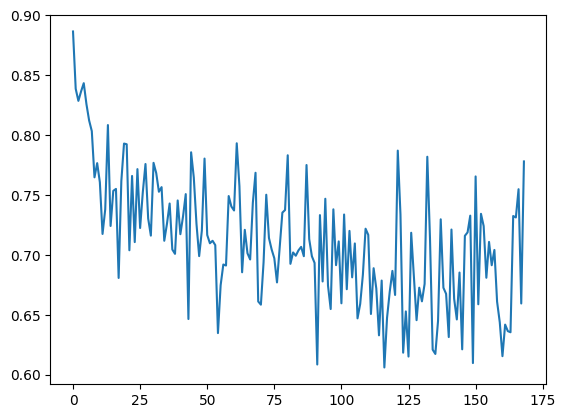

In [37]:
plt.plot(history_list_c[0]["train_losses"])

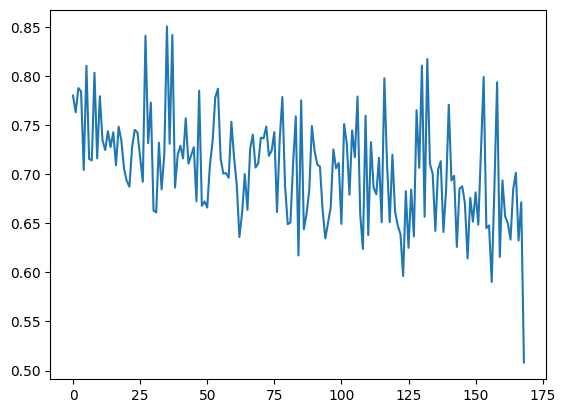

In [38]:
### Plot loss
plt.plot(history_list_c[1]["train_losses"])

### Bert with Conclusion and Premise

In [39]:
LEARNING_RATE_CP = LEARNING_RATE

In [40]:
### loop over seeds:
history_list_cp = []
for seed_idx, seed in enumerate(seeds):
    torch.manual_seed(seed)
    np.random.seed(seed)
    dls, model_cp, optimizer_cp = setup(
        datasets=datasets,
        learning_rate=LEARNING_RATE_CP,
        weight_decay=WEIGHT_DECAY,
        premise=True,
        stance=False,
    )

    history = train_eval(
        dls=dls,
        model=model_cp,
        optimizer=optimizer_cp,
        class_weights=class_weights,
        n_epochs=N_EPOCHS,
        save_name=f"conclusion_premise_{seed_idx}",
        use_stance=False,
    )
    history_list_cp.append(history)

Map:   0%|          | 0/5393 [00:00<?, ? examples/s]

PREMISE = True  STANCE = False
PREMISE = True  STANCE = False
PREMISE = True  STANCE = False
PREMISE = True  STANCE = False
PREMISE = True  STANCE = False
PREMISE = True  STANCE = False


Map:   0%|          | 0/1896 [00:00<?, ? examples/s]

PREMISE = True  STANCE = False
PREMISE = True  STANCE = False


Map:   0%|          | 0/1576 [00:00<?, ? examples/s]

PREMISE = True  STANCE = False
PREMISE = True  STANCE = False
Epoch 1/1


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

train_loss=0.6718, val_loss=0.6439,  train_acc=0.6939, val_acc=0.7068,  val_f1_overall=0.7456, val_f1_per_cat=[0.59901599 0.68266667 0.85099846 0.84963325]


Map:   0%|          | 0/5393 [00:00<?, ? examples/s]

PREMISE = True  STANCE = False
PREMISE = True  STANCE = False
PREMISE = True  STANCE = False
PREMISE = True  STANCE = False
PREMISE = True  STANCE = False
PREMISE = True  STANCE = False


Map:   0%|          | 0/1896 [00:00<?, ? examples/s]

PREMISE = True  STANCE = False
PREMISE = True  STANCE = False


Map:   0%|          | 0/1576 [00:00<?, ? examples/s]

PREMISE = True  STANCE = False
PREMISE = True  STANCE = False
Epoch 1/1


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

train_loss=0.6720, val_loss=0.6336,  train_acc=0.6984, val_acc=0.7276,  val_f1_overall=0.7499, val_f1_per_cat=[0.61505376 0.68189415 0.85555898 0.84694836]


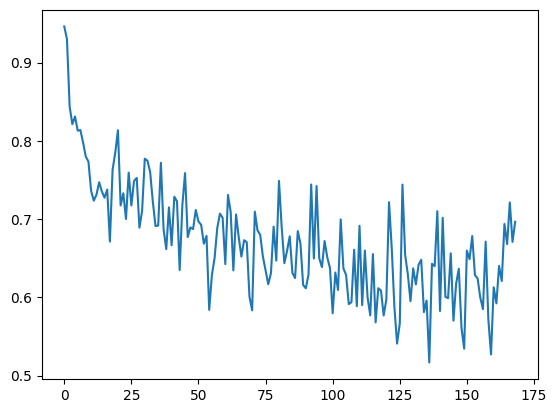

In [41]:
### Plot loss
plt.plot(history_list_cp[0]["train_losses"])

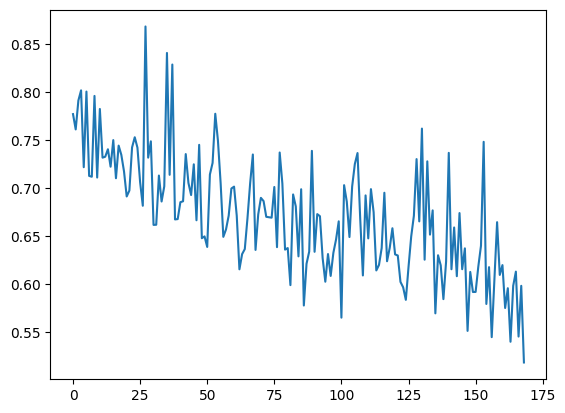

In [42]:
plt.plot(history_list_cp[1]["train_losses"])

### Bert with Conclusion Premise and Stance

In [43]:
LEARNING_RATE_CPS = LEARNING_RATE

In [44]:
### loop over seeds:
history_list_cps = []
for seed_idx, seed in enumerate(seeds):
    torch.manual_seed(seed)
    np.random.seed(seed)
    dls, model_cps, optimizer_cps = setup(
        datasets=datasets,
        learning_rate=LEARNING_RATE_CPS,
        weight_decay=WEIGHT_DECAY,
        premise=True,
        stance=True,
    )

    history = train_eval(
        dls=dls,
        model=model_cps,
        optimizer=optimizer_cps,
        class_weights=class_weights,
        n_epochs=N_EPOCHS,
        save_name=f"conclusion_premise_stance{seed_idx}",
        use_stance=True,
    )
    history_list_cps.append(history)

Map:   0%|          | 0/5393 [00:00<?, ? examples/s]

PREMISE = True  STANCE = True
PREMISE = True  STANCE = True
PREMISE = True  STANCE = True
PREMISE = True  STANCE = True
PREMISE = True  STANCE = True
PREMISE = True  STANCE = True


Map:   0%|          | 0/1896 [00:00<?, ? examples/s]

PREMISE = True  STANCE = True
PREMISE = True  STANCE = True


Map:   0%|          | 0/1576 [00:00<?, ? examples/s]

PREMISE = True  STANCE = True
PREMISE = True  STANCE = True
Epoch 1/1


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

train_loss=0.6747, val_loss=0.6559,  train_acc=0.6948, val_acc=0.7238,  val_f1_overall=0.7287, val_f1_per_cat=[0.53654342 0.67567568 0.84931507 0.85316379]


Map:   0%|          | 0/5393 [00:00<?, ? examples/s]

PREMISE = True  STANCE = True
PREMISE = True  STANCE = True
PREMISE = True  STANCE = True
PREMISE = True  STANCE = True
PREMISE = True  STANCE = True
PREMISE = True  STANCE = True


Map:   0%|          | 0/1896 [00:00<?, ? examples/s]

PREMISE = True  STANCE = True
PREMISE = True  STANCE = True


Map:   0%|          | 0/1576 [00:00<?, ? examples/s]

PREMISE = True  STANCE = True
PREMISE = True  STANCE = True
Epoch 1/1


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

train_loss=0.6726, val_loss=0.6356,  train_acc=0.6931, val_acc=0.7235,  val_f1_overall=0.7407, val_f1_per_cat=[0.56896552 0.68855932 0.85423729 0.85119412]


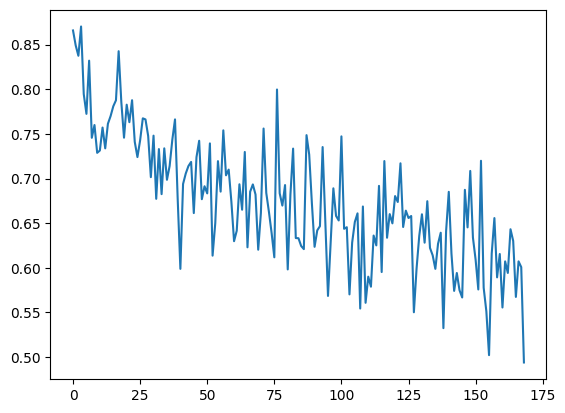

In [45]:
### Plot loss
plt.plot(history_list_cps[0]["train_losses"])

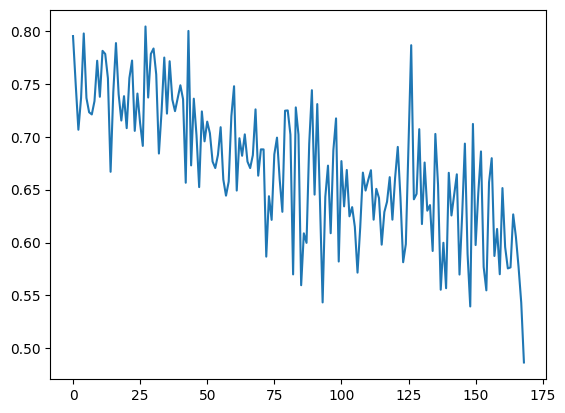

In [46]:
plt.plot(history_list_cps[1]["train_losses"])

In [47]:
for hl, name in zip(
    (
        history_list_c,
        history_list_cp,
        history_list_cps,
    ),
    ("C", "CP", "CPS"),
):
    print(name)
    for h, s in zip(hl, seeds):
        print(f"SEED = {s}")
        print(f"F1 overall = {h['f1_overall']:.4f}")
        print(f"F1 per cat = {[ f'{i:.4f}' for i in h['f1_per_cat'] ]}\n")

C
SEED = 333
F1 overall = 0.6571
F1 per cat = ['0.3041', '0.6224', '0.8485', '0.8533']

SEED = 666
F1 overall = 0.6625
F1 per cat = ['0.3121', '0.6360', '0.8485', '0.8533']

CP
SEED = 333
F1 overall = 0.7456
F1 per cat = ['0.5990', '0.6827', '0.8510', '0.8496']

SEED = 666
F1 overall = 0.7499
F1 per cat = ['0.6151', '0.6819', '0.8556', '0.8469']

CPS
SEED = 333
F1 overall = 0.7287
F1 per cat = ['0.5365', '0.6757', '0.8493', '0.8532']

SEED = 666
F1 overall = 0.7407
F1 per cat = ['0.5690', '0.6886', '0.8542', '0.8512']

